<a href="https://colab.research.google.com/github/sriharshams/data_synthesis/blob/master/build/Rival_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load libraries and check memory

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[13655322624, 12919607296]
[13655322624, 12912013312]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle
import gc
import os
import sys

from keras import applications
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf


def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC


    
def get_data_batch(train, batch_size, seed=0):
    # # random sampling - some samples will have excessively low or high sampling, but easy to implement
    # np.random.seed(seed)
    # x = train.loc[ np.random.choice(train.index, batch_size) ].values
    
    # iterate through shuffled indices, so every sample gets covered evenly
    start_i = (batch_size * seed) % len(train)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(train)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice( list(train.index), replace=False, size=len(train) ) # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix) # duplicate to cover ranges past the end of the set
    x = train.loc[ train_ix[ start_i: stop_i ] ].values
    
    return np.reshape(x, (batch_size, -1) )


    
def CheckAccuracy( x, g_z, data_cols, label_cols=[], seed=0, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 4, # for faster evaluation
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'auc', # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for faster evaluation

    y_pred = np.round(xgb_test.predict(dtest))

    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return SimpleAccuracy(y_pred, y_true) # assumes balanced real and generated datasets
    
def PlotData( x, g_z, data_cols, label_cols=[], seed=0, with_class=False, data_dim=2, save=False, prefix='' ):
    
    real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    if with_class:
        axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]], c=real_samples[label_cols[0]]/2 ) #, cmap='plasma'  )
        axarr[1].scatter( gen_samples[ data_cols[0]], gen_samples[ data_cols[1]], c=gen_samples[label_cols[0]]/2 ) #, cmap='plasma'  )
        
        # For when there are multiple one-hot encoded label columns
        # for i in range(len(label_cols)):
            # temp = real_samples.loc[ real_samples[ label_cols[i] ] == 1 ]
            # axarr[0].scatter( temp[data_cols[0]], temp[data_cols[1]], c='C'+str(i), label=i )
            # temp = gen_samples.loc[ gen_samples[ label_cols[i] ] == 1 ]
            # axarr[1].scatter( temp[data_cols[0]], temp[data_cols[1]], c='C'+str(i), label=i )
        
    else:
        axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]]) #, cmap='plasma'  )
        axarr[1].scatter( gen_samples[data_cols[0]], gen_samples[data_cols[1]]) #, cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[1].set_title('generated')   
    axarr[0].set_ylabel(data_cols[1]) # Only add y label to left plot
    for a in axarr: a.set_xlabel(data_cols[0]) # Add x label to both plots
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim()) # Use axes ranges from real data for generated data
    
    if save:
        plt.save( prefix + '.xgb_check.png' )
        
    plt.show()

    

#### Functions to define the layers of the networks used in the 'define_models' functions below
    
def generator_network(x, data_dim, base_n_count): 
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    x = layers.Dense(data_dim)(x)    
    return x
    
def generator_network_w_label(x, labels, data_dim, label_dim, base_n_count): 
    x = layers.concatenate([x,labels])
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    x = layers.Dense(data_dim)(x)    
    x = layers.concatenate([x,labels])
    return x
    
def discriminator_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    # x = layers.Dense(1)(x)
    return x
    
def critic_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(1, activation='sigmoid')(x)
    x = layers.Dense(1)(x)
    return x

    
    
#### Functions to define the keras network models    
    
def define_models_GAN(rand_dim, data_dim, base_n_count, type=None):
    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

    generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
    if type == 'Wasserstein':
        discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)
    else:
        discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

    generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model(generator_input_tensor))
    combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')
    
    return generator_model, discriminator_model, combined_model

def define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=None):
    generator_input_tensor = layers.Input(shape=(rand_dim, ))
    labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
    generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

    generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
    if type == 'Wasserstein':
        discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class
    else:
        discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

    generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
    discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
                                       outputs=[discriminator_output],
                                       name='discriminator')

    combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
    combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class
    
    return generator_model, discriminator_model, combined_model



#### Functions specific to the WGAN architecture
#### The train discrimnator step is separated out to facilitate pre-training of the discriminator by itself

def em_loss(y_coefficients, y_pred):
    # define earth mover distance (wasserstein loss)
    # literally the weighted average of the critic network output
    # this is defined separately so it can be fed as a loss function to the optimizer in the WGANs
    return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))

def train_discriminator_step(model_components, seed=0):
    
    [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path,

                        sess, _z, _x, _labels, _g_z, epsilon, x_hat, gradients, _gradient_penalty,
                        _disc_loss_generated, _disc_loss_real, _disc_loss, disc_optimizer,
                        show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses
                        ] = model_components
    
    if with_class:
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train, batch_size, seed=seed),
            _labels: get_data_batch(train, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    return d_l_g, d_l_r

def training_steps_WGAN(model_components):
    
    [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path,

                        sess, _z, _x, _labels, _g_z, epsilon, x_hat, gradients, _gradient_penalty,
                        _disc_loss_generated, _disc_loss_real, _disc_loss, disc_optimizer,
                        show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses
                        ] = model_components
    
    for i in range(starting_step, starting_step+nb_steps):
        K.set_learning_phase(1) # 1 = train

        # train the discriminator
        for j in range(k_d):
            d_l_g, d_l_r = train_discriminator_step(model_components, seed=i+j)
        disc_loss_generated.append(d_l_g)
        disc_loss_real.append(d_l_r)

        # train the generator
        for j in range(k_g):
            np.random.seed(i+j)
            z = np.random.normal(size=(batch_size, rand_dim))
            if with_class:
                labels = get_data_batch(train, batch_size, seed=i+j)[:,-label_dim:] # updated for class
                loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
            else:
                loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
        combined_loss.append(loss)

        # Determine xgb loss each step, after training generator and discriminator
        if not i % 10: # 2x faster than testing each step...
            K.set_learning_phase(0) # 0 = test
            test_size = 492 # test using all of the actual fraud data
            x = get_data_batch(train, test_size, seed=i)
            z = np.random.normal(size=(test_size, rand_dim))
            if with_class:
                labels = x[:,-label_dim:]
                g_z = generator_model.predict([z, labels])
            else:
                g_z = generator_model.predict(z)
            xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
            xgb_losses = np.append(xgb_losses, xgb_loss)
        
        if not i % log_interval:
            print('Step: {} of {}.'.format(i, starting_step + nb_steps))
            # K.set_learning_phase(0) # 0 = test
                        
            # loss summaries   
            print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
            print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )
            # print('Generator model loss: {}.'.format(combined_loss[-1]))
            # print('Discriminator model loss gen: {}.'.format(disc_loss_generated[-1]))
            # print('Discriminator model loss real: {}.'.format(disc_loss_real[-1]))
            # print('xgboost accuracy: {}'.format(xgb_losses[-1]) )
            
            if show:
                PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim, 
                            save=False, prefix= data_dir + cache_prefix + '_' + str(i) )

            # save model checkpoints
            model_checkpoint_base_name = data_dir + cache_prefix + '_{}_model_weights_step_{}.h5'
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
            pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(i) ,'wb'))
    
    return [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses]

def adversarial_training_WGAN(arguments, train, data_cols, label_cols=[], seed=0, starting_step=0):

    [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ] = arguments
            
    np.random.seed(seed)     # set random seed
    
    data_dim = len(data_cols)
    print('data_dim: ', data_dim)
    print('data_cols: ', data_cols)
    
    label_dim = 0
    with_class = False
    if len(label_cols) > 0: 
        with_class = True
        label_dim = len(label_cols)
        print('label_dim: ', label_dim)
        print('label_cols: ', label_cols)
    
    # define network models
    
    K.set_learning_phase(1) # 1 = train
    
    if with_class:
        cache_prefix = 'WCGAN'
        generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
    else:
        cache_prefix = 'WGAN'
        generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
    
    
    # construct computation graph for calculating the gradient penalty (improved WGAN) and training the discriminator

    _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
    _labels = None
    if with_class:  
        _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim))    
        _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
        _g_z = generator_model(inputs=[_z, _labels]) # updated for class    
    else:      
        _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
        _g_z = generator_model(_z)
    
    epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
    x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
    gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
    _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

    # calculate discriminator's loss
    _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
    _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
    _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

    # update f by taking an SGD step on mini-batch loss LD(f)
    disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(
        _disc_loss, var_list=discriminator_model.trainable_weights)

    sess = K.get_session()

    # compile models

    adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

    discriminator_model.trainable = False
    combined_model.compile(optimizer=adam, loss=[em_loss])

    combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []
    
    model_components = [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path,

                        sess, _z, _x, _labels, _g_z, epsilon, x_hat, gradients, _gradient_penalty,
                        _disc_loss_generated, _disc_loss_real, _disc_loss, disc_optimizer,
                        show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses
                        ]

    if show:
        print(generator_model.summary())
        print(discriminator_model.summary())
        print(combined_model.summary())

    if loss_pickle_path:
        print('Loading loss pickles')
        [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(open(loss_pickle_path,'rb'))
    if generator_model_path:
        print('Loading generator model')
        generator_model.load_weights(generator_model_path) #, by_name=True)
    if discriminator_model_path:
        print('Loading discriminator model')
        discriminator_model.load_weights(discriminator_model_path) #, by_name=True)
    else:
        print('pre-training the critic...')
        K.set_learning_phase(1) # 1 = train
        for i in range(critic_pre_train_steps):
            if i%20==0:
                print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
            loss = train_discriminator_step(model_components, seed=i)
        print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

    model_components = [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path,

                        sess, _z, _x, _labels, _g_z, epsilon, x_hat, gradients, _gradient_penalty,
                        _disc_loss_generated, _disc_loss_real, _disc_loss, disc_optimizer,
                        show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses
                        ]
        
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = training_steps_WGAN(model_components)
   


#### Functions specific to the vanilla GAN architecture   
        
def training_steps_GAN(model_components):
    
    [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path, show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses ] = model_components  
    
    for i in range(starting_step, starting_step+nb_steps):
        K.set_learning_phase(1) # 1 = train

        # train the discriminator
        for j in range(k_d):
            np.random.seed(i+j)
            z = np.random.normal(size=(batch_size, rand_dim))
            x = get_data_batch(train, batch_size, seed=i+j)
            
            if with_class:
                labels = x[:,-label_dim:]
                g_z = generator_model.predict([z, labels])
            else:
                g_z = generator_model.predict(z)
#             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
#             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
#             d_l_r = discriminator_model.train_on_batch(x, classes)
            
            d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
            d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
            # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
            # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
        disc_loss_real.append(d_l_r)
        disc_loss_generated.append(d_l_g)
        
        # train the generator
        for j in range(k_g):
            np.random.seed(i+j)
            z = np.random.normal(size=(batch_size, rand_dim))
            if with_class:
                # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
                loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
            else:
                # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
                loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
        combined_loss.append(loss)
        
        # Determine xgb loss each step, after training generator and discriminator
        if not i % 10: # 2x faster than testing each step...
            K.set_learning_phase(0) # 0 = test
            test_size = 492 # test using all of the actual fraud data
            x = get_data_batch(train, test_size, seed=i)
            z = np.random.normal(size=(test_size, rand_dim))
            if with_class:
                labels = x[:,-label_dim:]
                g_z = generator_model.predict([z, labels])
            else:
                g_z = generator_model.predict(z)
            xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
            xgb_losses = np.append(xgb_losses, xgb_loss)

        # Saving weights and plotting images
        if not i % log_interval:
            print('Step: {} of {}.'.format(i, starting_step + nb_steps))
            K.set_learning_phase(0) # 0 = test
                        
            # loss summaries      
            print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
            print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )            
            # print('Generator model loss: {}.'.format(combined_loss[-1]))
            # print('Discriminator model loss gen: {}.'.format(disc_loss_generated[-1]))
            # print('Discriminator model loss real: {}.'.format(disc_loss_real[-1]))
            # print('xgboost accuracy: {}'.format(xgb_losses[-1]) )
            
            if show:
                PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim, 
                            save=False, prefix= data_dir + cache_prefix + '_' + str(i) )
            
            # save model checkpoints
            model_checkpoint_base_name = data_dir + cache_prefix + '_{}_model_weights_step_{}.h5'
            generator_model.save_weights(model_checkpoint_base_name.format('generator', i))
            discriminator_model.save_weights(model_checkpoint_base_name.format('discriminator', i))
            pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(i) ,'wb'))
    
    return [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses]
    
def adversarial_training_GAN(arguments, train, data_cols, label_cols=[], seed=0, starting_step=0):

    [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ] = arguments
    
    np.random.seed(seed)     # set random seed
    
    data_dim = len(data_cols)
    print('data_dim: ', data_dim)
    print('data_cols: ', data_cols)
    
    label_dim = 0
    with_class = False
    if len(label_cols) > 0: 
        with_class = True
        label_dim = len(label_cols)
        print('label_dim: ', label_dim)
        print('label_cols: ', label_cols)
    
    # define network models
    
    K.set_learning_phase(1) # 1 = train
    
    if with_class:
        cache_prefix = 'CGAN'
        generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
    else:
        cache_prefix = 'GAN'
        generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
    
    # compile models

    adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

    generator_model.compile(optimizer=adam, loss='binary_crossentropy')
    discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
    discriminator_model.trainable = False
    combined_model.compile(optimizer=adam, loss='binary_crossentropy')
    
    if show:
        print(generator_model.summary())
        print(discriminator_model.summary())
        print(combined_model.summary())

    combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []
    
    if loss_pickle_path:
        print('Loading loss pickles')
        [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(open(loss_pickle_path,'rb'))
    if generator_model_path:
        print('Loading generator model')
        generator_model.load_weights(generator_model_path, by_name=True)
    if discriminator_model_path:
        print('Loading discriminator model')
        discriminator_model.load_weights(discriminator_model_path, by_name=True)

    model_components = [ cache_prefix, with_class, starting_step,
                        train, data_cols, data_dim,
                        label_cols, label_dim,
                        generator_model, discriminator_model, combined_model,
                        rand_dim, nb_steps, batch_size, 
                        k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
                        data_dir, generator_model_path, discriminator_model_path, show,
                        combined_loss, disc_loss_generated, disc_loss_real, xgb_losses ]
        
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = training_steps_GAN(model_components)
        


#### Functions specific to the DRAGAN architecture
#### Note the DRAGAN is implemented in tensorflow without Keras libraries 
#### https://github.com/kodalinaveen3/DRAGAN
        
def sample_z(m, n): # updated to normal distribution
#     return np.random.uniform(-1., 1., size=[m, n])
    return np.random.normal(size=[m, n])

def xavier_init(size): # updated to uniform distribution using standard xavier formulation
#     in_dim = size[0]
#     xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
#     return tf.random_normal(shape=size, stddev=xavier_stddev, seed=global_seed)
    xavier_range = tf.sqrt( 6 / ( size[0] + size[1] ) )
    return tf.random_uniform(shape=size, minval=-xavier_range, maxval=xavier_range)

def get_perturbed_batch(minibatch):
    return minibatch + 0.5 * minibatch.std() * np.random.random(minibatch.shape)

     
def G(z, G_W, G_b): # The Generator Network
    # for i in range(len(G_layer_dims)-2):
    for i in range(len(G_W)-1):
        z = tf.nn.relu(tf.matmul(z, G_W[i]) + G_b[i])
#         print(i,G_W[i],z)
    return tf.matmul(z, G_W[-1]) + G_b[-1]     
    
def D(x, D_W, D_b): # The Discriminator Network
    # for i in range(len(D_layer_dims)-2):
    for i in range(len(D_W)-1):
        x = tf.nn.relu(tf.matmul(x, D_W[i]) + D_b[i])
    return tf.nn.sigmoid(tf.matmul(x, D_W[-1]) + D_b[-1])
     
     
def define_DRAGAN_network( X_dim=2, h_dim=128, z_dim=2, lambda0=10, learning_rate=1e-4, mb_size=128, seed=0 ):
    
    X = tf.placeholder(tf.float32, shape=[None, X_dim], name='X' )
    X_p = tf.placeholder(tf.float32, shape=[None, X_dim], name='X_p' )
    z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z' )

    D_layer_dims = [X_dim, h_dim*4, h_dim*2, h_dim, 1 ]
    D_W, D_b = [], []   
    for i in range(len(D_layer_dims)-1):
        D_W.append( tf.Variable( xavier_init([D_layer_dims[i], D_layer_dims[i+1]] ), name='D_W'+str(i) ) )
    #     D_W.append( tf.Variable(  initializer=tf.contrib.layers.xavier_initializer(seed=global_seed) ) # working towards using tf's own xavier initializer
        D_b.append( tf.Variable( tf.zeros(shape=[D_layer_dims[i+1]]), name='D_b'+str(i) ) )
    theta_D = D_W + D_b

    G_layer_dims = [z_dim, h_dim, h_dim*2, h_dim*4, X_dim ]
    G_W, G_b = [], []
    for i in range(len(G_layer_dims)-1):
        G_W.append( tf.Variable( xavier_init([G_layer_dims[i], G_layer_dims[i+1]] ), name='G_W'+str(i) ) )
        G_b.append( tf.Variable( tf.zeros(shape=[G_layer_dims[i+1]]), name='g_b'+str(i) ) )
    theta_G = G_W + G_b
    # print( theta_D + theta_G )
        
    G_sample = G(z, G_W, G_b)
    D_real = D(X, D_W, D_b)
    D_fake = D(G_sample, D_W, D_b)
    D_real_perturbed = D(X_p, D_W, D_b)

    # D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
    # D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
    # disc_cost = D_loss_real + D_loss_fake 
    # gen_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))
    D_loss_real = tf.reduce_mean(tf.log( D_real ))
    D_loss_fake = tf.reduce_mean(tf.log( 1 - D_fake ))
    disc_cost = - D_loss_real - D_loss_fake
    gen_cost = D_loss_fake

    #Gradient penalty
    alpha = tf.random_uniform(
        shape=[mb_size,1], 
        minval=0.,
        maxval=1.) # do not set seed
        
    differences = X_p - X
    interpolates = X + (alpha*differences)
    gradients = tf.gradients(D(interpolates, D_W, D_b), [interpolates])[0]
    # slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    # gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    gradient_penalty = tf.square(tf.norm(gradients, ord=2) - 1.0 )  # corrected?

    disc_cost += lambda0 * gradient_penalty / mb_size # corrected?

    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(gen_cost, var_list=theta_G)
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(disc_cost, var_list=theta_D)
    
    return [ D_solver, disc_cost, D_loss_real, D_loss_fake,
                X, X_p, z,
                G_solver, gen_cost, G_sample ]
    


 
# End of function list

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# get data from https://www.kaggle.com/mlg-ulb/creditcardfraud
data = pd.read_csv("/content/gdrive/My Drive/insight-ai/scratch/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


Text(0, 0.5, 'Frequency')

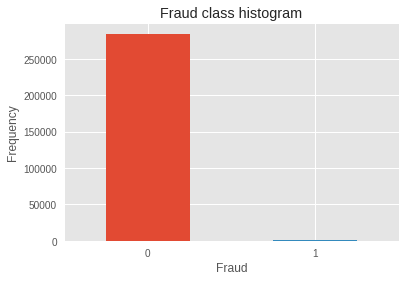

In [7]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar', rot=0)
plt.title("Fraud class histogram")
plt.xlabel("Fraud")
plt.ylabel("Frequency")

In [0]:
# Put columns in order of importance for xgboost fraud detection (from that section)

# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'V26', 'V17', 'Amount', 'V7', 'V21', 'V28', 'V20', 'V3', 'V18', 'V8', 'V13', 'V22', 'V16', 'V11', 'V19', 'V27', 'V5', 'V6', 'V25', 'V15', 'V24', 'V9', 'V1', 'V2', 'V23', 'Class']
# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'Amount', 'V26', 'V17', 'Time', 'V7', 'V28', 'V21', 'V19', 'V8', 'V3', 'V22', 'V20', 'V25', 'V11', 'V6', 'V16', 'V27', 'V5', 'V18', 'V9', 'V1', 'V2', 'V15', 'V23', 'V24', 'V13', 'Class']
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']

data = data[ sorted_cols ].copy()

In [9]:
# Add KMeans generated classes to fraud data - see classification section for more details on this

import sklearn.cluster as cluster

train = data[ data['Class']==1 ].copy()

print(train.shape)

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}

print(data_cols)
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])
print(labels[100])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels
print(fraud_w_classes.columns)
print(fraud_w_classes.columns)

(492, 31)
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
0
   count
0    281
1    211
Index(['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8',
       'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16',
       'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23',
       'Class'],
      dtype='object')
Index(['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8',
       'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16',
       'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23',
       'Class'],
      dtype='object')


In [0]:
# Function to create toy spiral dataset (looks like swiss roll)

def create_toy_spiral_df( n, seed=0):
    np.random.seed(seed)
    toy = np.array([ [ (i/10+1) * np.sin(i), -(i/10+1) * np.cos(i) ] for i in np.random.uniform(0,3*np.pi,size=n) ])
    toy = pd.DataFrame( toy, columns=[ ['v'+str(i+1) for i in range(2)] ])
    return toy

# toy = create_toy_spiral_df(1000)    
# plt.scatter( toy['v1'], toy['v2'] ) ;

In [0]:
# Function to create toy dataset of multiple groups of normal distributions in n dimensions

def create_toy_df( n, n_dim, n_classes, seed=0):
    toy = pd.DataFrame(columns=[ ['v'+str(i+1) for i in range(n_dim)] + ['Class'] ])
    toy_cols = toy.columns
    np.random.seed(seed)
    for class0 in range(n_classes):
        center0s = np.random.randint(-10,10,size=n_dim)/10
        var0s = np.random.randint(1,3,size=n_dim)/10
        temp = np.array([[class0]]*n)
        for dim0 in range(n_dim):
            temp = np.hstack( [np.random.normal(center0s[dim0],var0s[dim0],n).reshape(-1,1), temp] )
        toy = pd.concat([toy,pd.DataFrame(temp,columns=toy_cols)],axis=0).reset_index(drop=True)
    return toy

# toy = create_toy_df(n=1000,n_dim=2,n_classes=2,seed=0)
# plt.scatter(toy[toy.columns[0]],toy[toy.columns[1]],c=toy['Class'], alpha=0.2) ;

In [12]:
# Load the credit card data

# Original data available from:
# https://www.kaggle.com/dalpozz/creditcardfraud

#data = pd.read_csv("data/creditcard.csv.zip")
print(data.shape)
print(data.columns)
data.head(3)

(284807, 31)
Index(['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8',
       'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16',
       'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23',
       'Class'],
      dtype='object')


,V14,V4,V10,V17,Time,V12,V26,Amount,V21,V8,...,V25,V24,V18,V2,V1,V5,V15,V9,V23,Class
0,-0.311169,1.378155,0.090794,0.207971,0.0,-0.617801,-0.189115,149.62,-0.018307,0.098698,...,0.128539,0.066928,0.025791,-0.072781,-1.359807,-0.338321,1.468177,0.363787,-0.110474,0
1,-0.143772,0.448154,-0.166974,-0.114805,0.0,1.065235,0.125895,2.69,-0.225775,0.085102,...,0.167170,-0.339846,-0.183361,0.266151,1.191857,0.060018,0.635558,-0.255425,0.101288,0
2,-0.165946,0.379780,0.207643,1.109969,1.0,0.066084,-0.139097,378.66,0.247998,0.247676,...,-0.327642,-0.689281,-0.121359,-1.340163,-1.358354,-0.503198,2.345865,-1.514654,0.909412,0


In [13]:
# data columns will be all other columns except class

label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('# of data columns: ',len(data_cols))

['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23']
# of data columns:  30


In [14]:
# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [15]:
# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()

0

In [16]:
# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 1062
Fraud duplicates 19
Total duplicates 1081
Fraction duplicated 0.00379555277784605


Last time value: 48.00


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


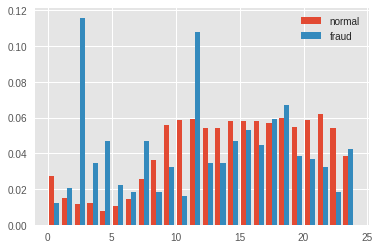

In [17]:
# 'Time' is seconds from first transaction in set
# 48 hours worth of data
# Let's convert time to time of day, in hours

print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600 ) )

data['Time'] = ( data['Time'].values / 3600 ) % 24

plt.hist( [ data.loc[ data['Class']==0, 'Time'], data.loc[ data['Class']==1, 'Time'] ],
         normed=True, label=['normal','fraud'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()

# Looks like normal transactions have a bias towards 8am to midnight
# Fraud has spikes at 2-3am and noon

In [18]:
# several columns heavily skewed, 'Amount' the highest (besides Class)

data.skew()

V14       -1.995176
V4         0.676292
V10        1.187141
V17       -3.844914
Time      -0.499981
V12       -2.278401
V26        0.576693
Amount    16.977724
V21        3.592991
V8        -8.521944
V11        0.356506
V7         2.553907
V28       11.192091
V19        0.109192
V3        -2.240155
V22       -0.213258
V6         1.826581
V20       -2.037155
V27       -1.170209
V16       -1.100966
V13        0.065233
V25       -0.415793
V24       -0.552499
V18       -0.259880
V2        -4.624866
V1        -3.280667
V5        -2.425901
V15       -0.308423
V9         0.554680
V23       -5.875140
Class     23.997579
dtype: float64

In [19]:
# Minimum 'Amount' is 0
# 0's account for 0.6% of the data set

print( data['Amount'].min() )
print( np.sum( data['Amount']==0 ) )
# print( np.sum( data['Amount']<0.01 ) )
print( np.sum( data['Amount']==0 ) / len(data) )

0.0
1825
0.006407848121710491


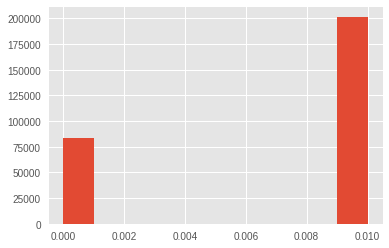

In [20]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['Amount'].mod(0.01).hist() ;

In [21]:
# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print( data.Amount.value_counts().head(15) )

1.00     13688
1.98      6044
0.89      4872
9.99      4747
15.00     3280
0.76      2998
10.00     2950
1.29      2892
1.79      2623
0.99      2304
20.00     2002
0.00      1825
8.99      1811
11.50     1741
4.49      1579
Name: Amount, dtype: int64


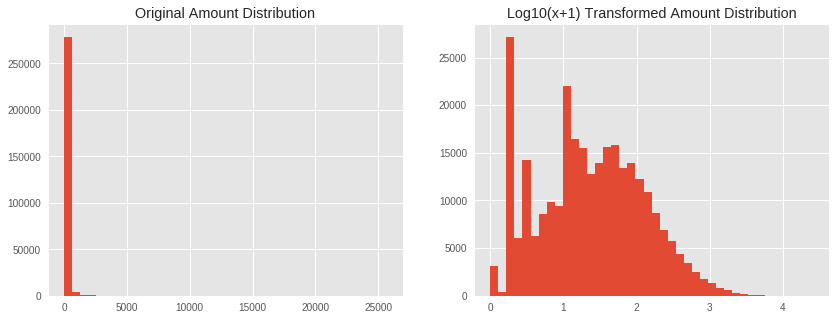

In [22]:
# Log transform amount values to give more normal distribution

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [0]:
# Use log transformed data

data['Amount'] = d0

In [24]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles

,V14,V4,V10,V17,Time,V12,V26,Amount,V21,V8,...,V13,V25,V24,V18,V2,V1,V5,V15,V9,V23
min,-7.342516,-4.163262,-5.209875,-5.702709,0.025833,-5.702560,-1.276676,0.000000,-5.490204,-13.102174,...,-3.103261,-2.403083,-2.001248,-3.351918,-15.126221,-16.044343,-9.408512,-3.185304,-3.305247,-5.452756
max,3.865350,6.235906,9.134652,4.054770,23.965278,2.739501,2.251097,3.477266,7.879007,6.135087,...,3.237774,1.873743,1.246819,2.674716,7.852129,2.344685,8.074611,2.634778,5.960836,4.759942
mean,0.005590,-0.003827,-0.001320,0.007291,14.543063,0.006787,-0.001117,1.375513,-0.002930,0.011022,...,-0.000105,0.000504,0.000089,0.001926,0.012756,0.020195,0.002532,0.000326,-0.002363,0.002081
stdev,0.882351,1.383725,0.981458,0.720282,5.827070,0.935579,0.474011,0.710045,0.550113,0.956445,...,0.984448,0.505554,0.596816,0.817122,1.429787,1.814661,1.208541,0.904186,1.064801,0.433626


In [0]:
# Center and scale the data using the percentile data we just generated

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

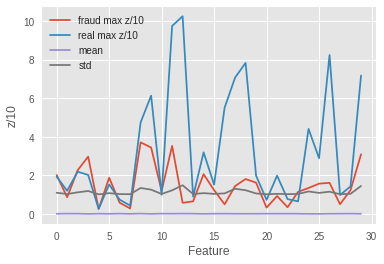

In [26]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ;

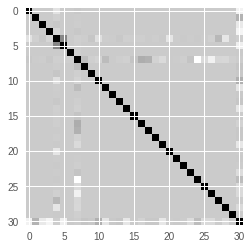

In [27]:
# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr('pearson')
plt.imshow(corr0) ;

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


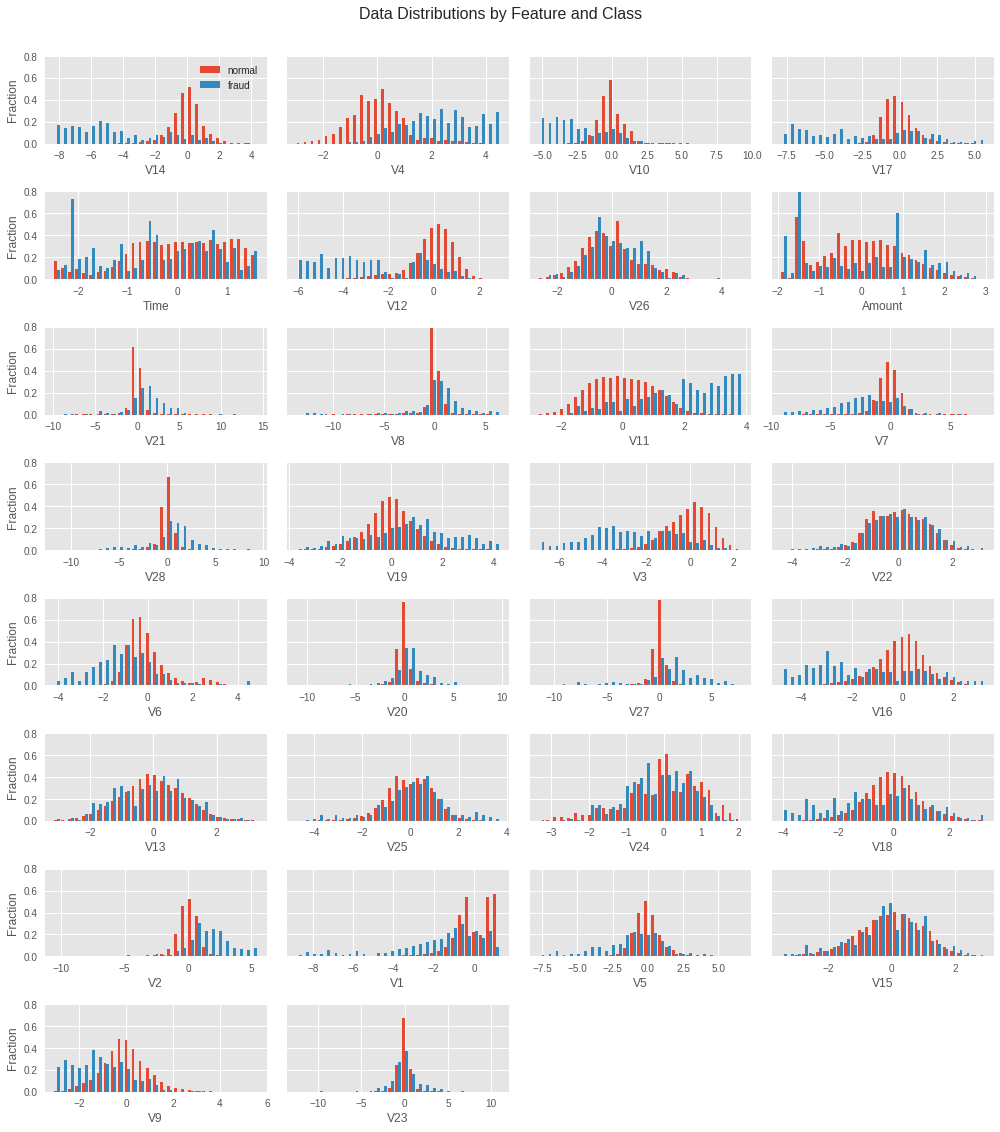

In [28]:
# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [0]:
# Save engineered dataset for use in analysis
# Save as pickle for faster reload

pickle.dump(data, open( '/content/gdrive/My Drive/insight-ai/scratch/credicard.engineered.pkl','wb'))

In [30]:
# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

31
Index(['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8',
       'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16',
       'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23',
       'Class'],
      dtype='object')


In [0]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

def f1(preds, dtrain):
    labels = dtrain.get_label()
    preds_bin = [1. if preds_cont > 0.5 else 0. for preds_cont in preds] # binaryzing your output
    return 'f1',  f1_score(labels, preds_bin)

In [32]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  284315 492
train, test:  199364 85443


In [33]:
# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
print( f1( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  2
('recall', 0.75)
('precision', 0.9173553719008265)
('roc_auc', 0.908619845591532)
('f1', 0.825278810408922)
Confusion Matrix


,Pred 0,Pred 1
True 0,85285,10
True 1,37,111


Accuracy : 0.9994499256814484


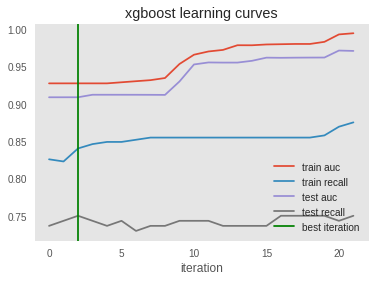

In [34]:
# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

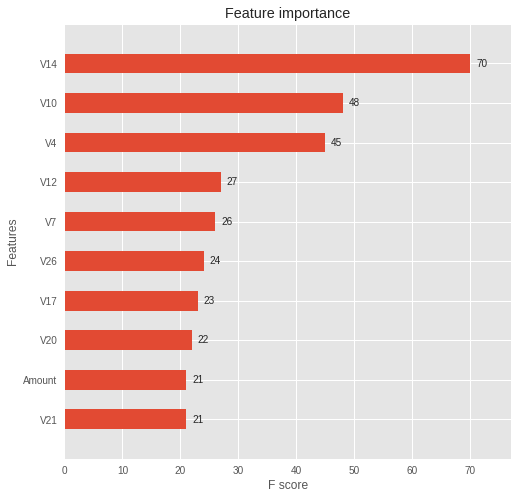

In [35]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [36]:
# Generate list of features sorted by importance in detecting fraud
# https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )

['V14', 'V10', 'V4', 'V12', 'V7', 'V26', 'V17', 'V20', 'V21', 'Amount', 'V28', 'Time', 'V11', 'V8', 'V25', 'V19', 'V22', 'V1', 'V27', 'V5', 'V16', 'V9', 'V6', 'V15', 'V3', 'V23', 'V24', 'V18', 'V13', 'V2', 'Class']


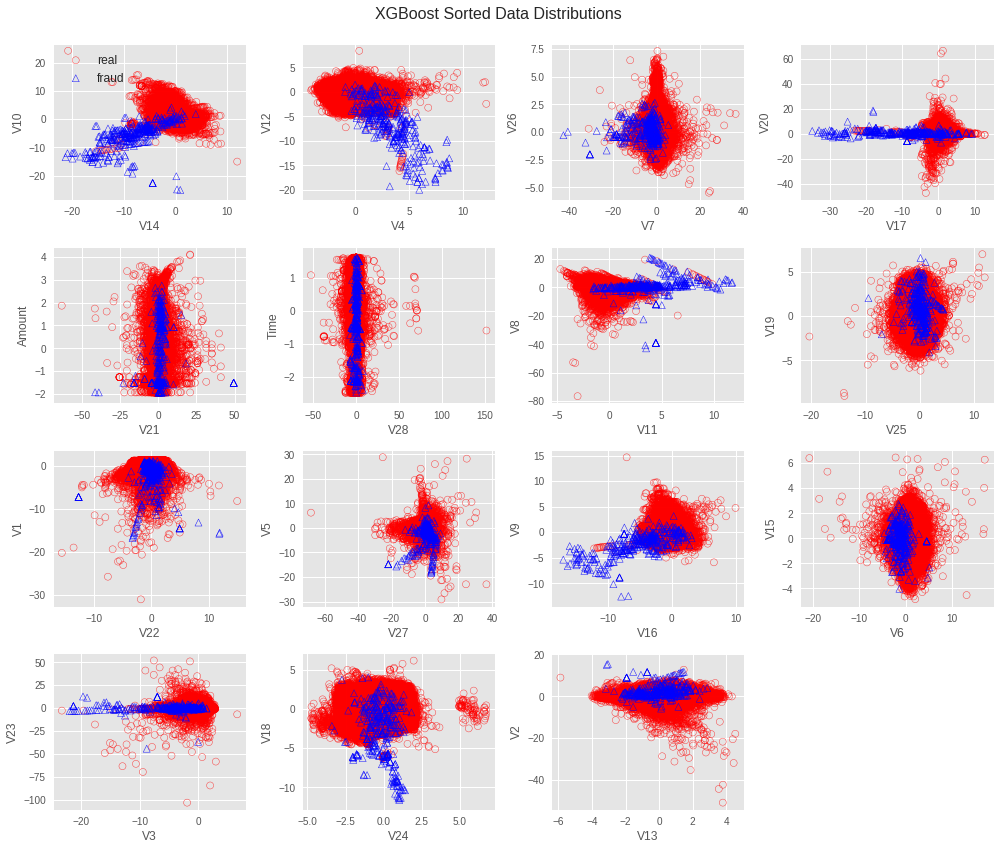

In [37]:
# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()

In [38]:
# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.2682695795279726
0.7196856730011519
1.9306977288832496
5.17947467923121
13.894954943731374
37.27593720314938
100.0


,ratio,best,test-auc-mean,test-auc-std,test-recall-mean,test-recall-std,train-auc-mean,train-auc-std,train-recall-mean,train-recall-std
0,0.100000,0,0.930606,0.101885,0.965617,0.009705,0.994223,0.005743,0.986262,0.003127
1,0.268270,0,0.956094,0.029604,0.938758,0.032029,0.996152,0.001399,0.976062,0.008418
2,0.719686,1,0.968658,0.003994,0.904717,0.011776,0.997173,0.000464,0.976599,0.009089
3,1.930698,0,0.948344,0.023097,0.876489,0.029017,0.978211,0.004863,0.924388,0.005483
4,5.179475,0,0.948964,0.004668,0.844650,0.030436,0.962005,0.002299,0.890889,0.010578
5,13.894955,0,0.940642,0.017151,0.838355,0.038594,0.954568,0.003276,0.872450,0.006503
6,37.275937,0,0.922112,0.029138,0.826606,0.056940,0.930331,0.006132,0.841476,0.015474
7,100.000000,0,0.916925,0.025282,0.801593,0.042431,0.922584,0.006382,0.825135,0.009177


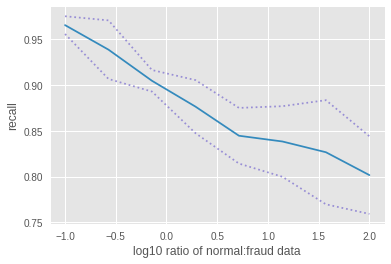

In [39]:
# Recall decreases as more normal data is added

# metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()

In [0]:
# load clustering libraries

import sklearn.cluster as cluster

In [0]:
# hdbscan not in kaggle/python at present

#!pip3 install hdbscan
#import hdbscan

In [42]:
# Set up training set to consist of only fraud data

train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1    492


In [43]:
%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]

CPU times: user 9.39 s, sys: 34.8 ms, total: 9.43 s
Wall time: 9.44 s


0 KMeans
1 Agglomerative


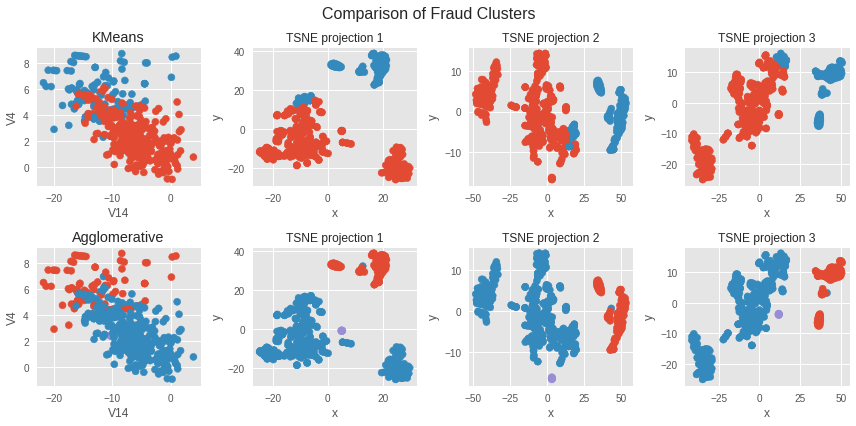

CPU times: user 2.56 s, sys: 1.24 s, total: 3.79 s
Wall time: 2.23 s


In [44]:
%%time 

# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
#    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
#plt.savefig('plots/Fraud_Cluster_Diagram.png')
plt.show()

In [45]:
# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

   count
0    357
1    135


In [46]:
# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )

Top eight features:  [['V17', 11], ['V10', 5], ['V7', 3], ['V3', 3], ['V4', 2], ['V11', 1], ['V15', 1], ['V28', 1]]


GAN setup and training

Table of contents

Resources:


https://github.com/wayaai/GAN-Sandbox 

http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html


Conversion of Waya.ai GAN and WGAN

1.   Remove convolutional layers
2.   Remove ResNeXt
3.   Add simple dense networks
4.   Convert WGAN back to simple GAN
5.   Use common functions as much as possible

For these functions I've passed the arguments as lists because it was easy to implement.

Standard solutions (because they are more stable) include using keyword dictionaries or objects, but those create a larger code base.

In [0]:
rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = '/content/gdrive/My Drive/cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim:  30
data_cols:  ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23']
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.cast instead.
Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.6689, 0.7380, 0.6688, 0.9898
D Real - D Gen: -0.0692


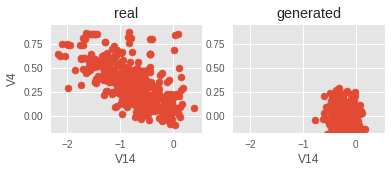

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8647, 0.7070, 0.5783, 0.9695
D Real - D Gen: -0.1287


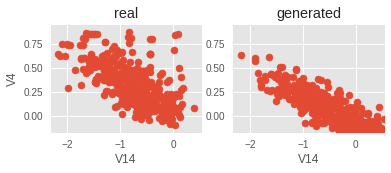

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8602, 0.7059, 0.6302, 0.9878
D Real - D Gen: -0.0757


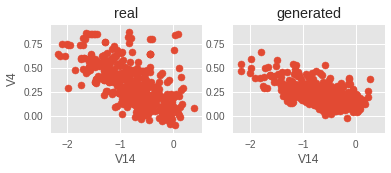

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0666, 0.6336, 0.6418, 0.9756
D Real - D Gen: 0.0082


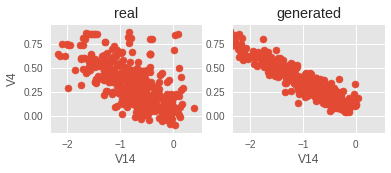

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8691, 0.8323, 0.5961, 0.9695
D Real - D Gen: -0.2362


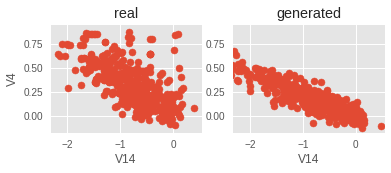

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0770, 0.5788, 0.5940, 0.9675
D Real - D Gen: 0.0151


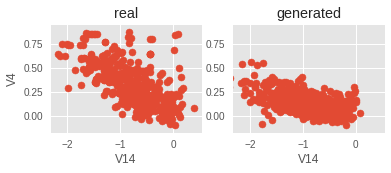

data_dim:  30
data_cols:  ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23']
label_dim:  1
label_cols:  ['Class']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 33)           0           input_3[0][0]                    
                                      

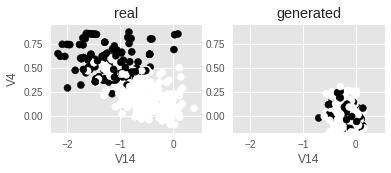

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2688, 0.6107, 0.7911, 0.9959
D Real - D Gen: 0.1804


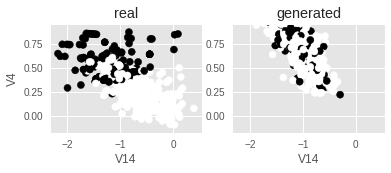

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2162, 0.6021, 0.6034, 0.9817
D Real - D Gen: 0.0013


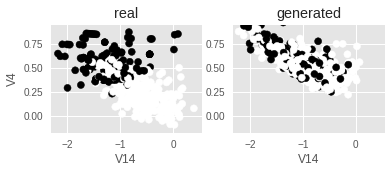

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2002, 0.5337, 0.6981, 0.9878
D Real - D Gen: 0.1644


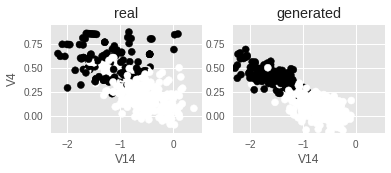

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0616, 0.6179, 0.5889, 0.9573
D Real - D Gen: -0.0290


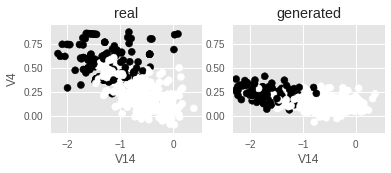

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2612, 0.4942, 0.6568, 0.9776
D Real - D Gen: 0.1626


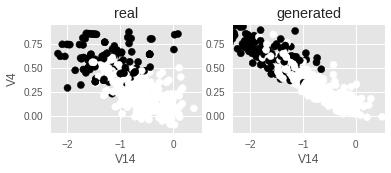

CPU times: user 45.9 s, sys: 6.43 s, total: 52.3 s
Wall time: 49.6 s


In [48]:
%%time

# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

data_dim:  30
data_cols:  ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 30)                15390     
Total params: 184,222
Trainable params: 18

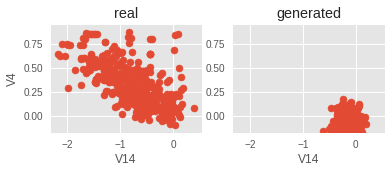

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0412, -0.0395, 0.0469, 0.8699
D Real - D Gen: 0.0864


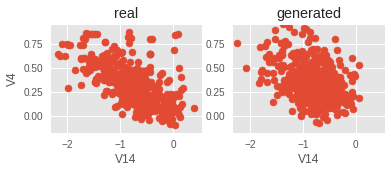

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0079, -0.0090, 0.0660, 0.8598
D Real - D Gen: 0.0751


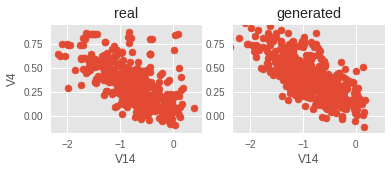

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0163, -0.0176, 0.0638, 0.8252
D Real - D Gen: 0.0814


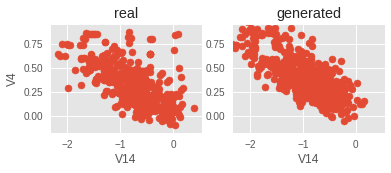

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0269, -0.0312, 0.0379, 0.7846
D Real - D Gen: 0.0691


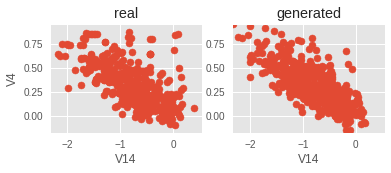

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0339, -0.0359, 0.0382, 0.7927
D Real - D Gen: 0.0742


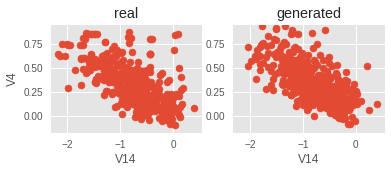

data_dim:  30
data_cols:  ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23']
label_dim:  1
label_cols:  ['Class']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 33)           0           input_8[0][0]                    
                                      

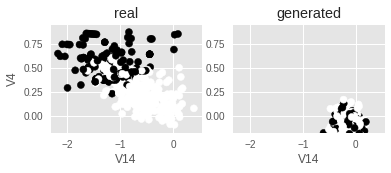

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0113, 0.0061, 0.1123, 0.8902
D Real - D Gen: 0.1061


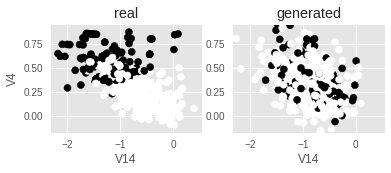

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0241, 0.0283, 0.1121, 0.8211
D Real - D Gen: 0.0838


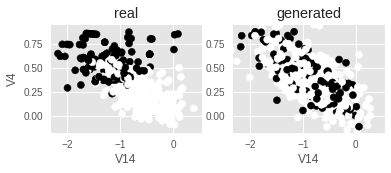

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0298, 0.0228, 0.1222, 0.8354
D Real - D Gen: 0.0994


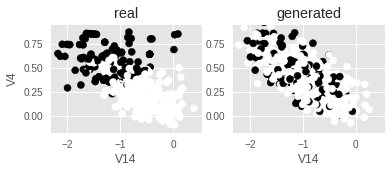

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0075, 0.0085, 0.0902, 0.8028
D Real - D Gen: 0.0817


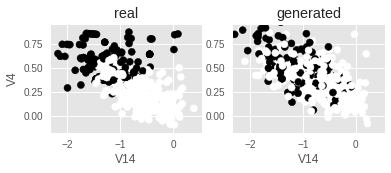

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0042, 0.0178, 0.1012, 0.7683
D Real - D Gen: 0.0834


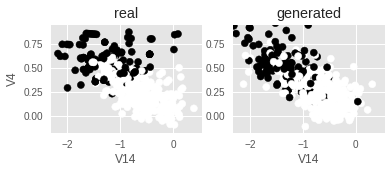

CPU times: user 1min 7s, sys: 8.68 s, total: 1min 16s
Wall time: 1min 12s


In [49]:
%%time

# Training the WGAN and WCGAN architectures

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [0]:
# For reloading loss data from pickles

prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

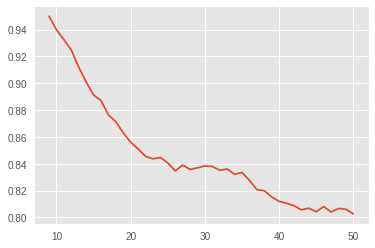

In [51]:
# plt.plot( xgb_losses[:] ) ;
w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

In [52]:
# Look for the step with the lowest xgboost accuracy, and the lowest step saved (every 100)

best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

500 0.7682926829268293
500 0.7682926829268293


In [53]:
# Look for the step with the lowest critic loss, and the lowest step saved (every 100)

delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

465 0.04904812
0 0.06622596


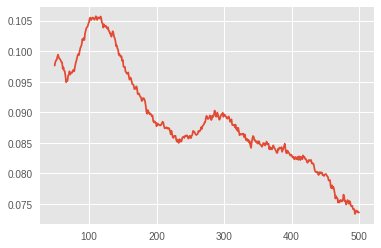

In [54]:
# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 50
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.xlim([9000,10000])
# plt.ylim([0.03,0.05])

In [56]:
print("READ HERE GANS TRAIN")
seed = 17

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('/content/gdrive/My Drive/cache/CGAN_generator_model_weights_step_500.h5')


# with_class = False
# train = train_no_label
# label_cols = []
# # generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
# # generator_model.load_weights('cache/WGAN_generator_model_weights_step_4800.h5')

# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/GAN_generator_model_weights_step_5000.h5')

READ HERE GANS TRAIN


In [0]:
# Now generate some new data

test_size = 492 # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=i+j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

0.9878048780487805


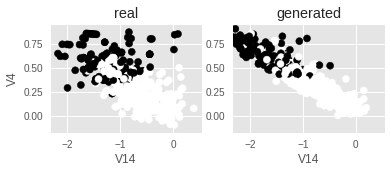

In [58]:
# Check using the same functions used during GAN training

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [59]:
# Now we can train and test an xgboost classifier on our generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

# dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] )
# dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] )
# dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] )

# dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
# dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
# y_true = dlabels

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )

0.99


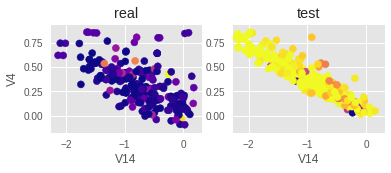

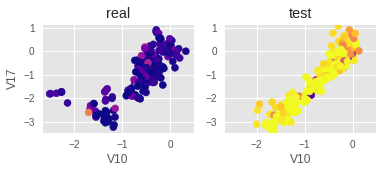

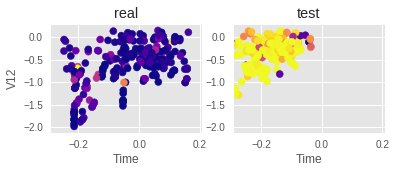

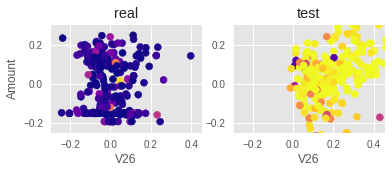

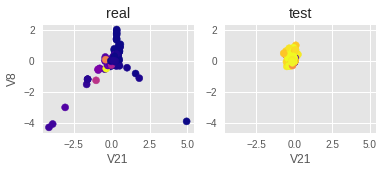

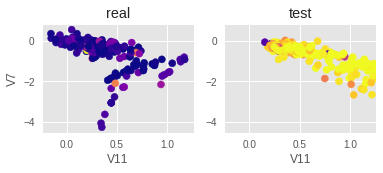

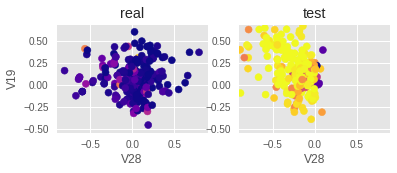

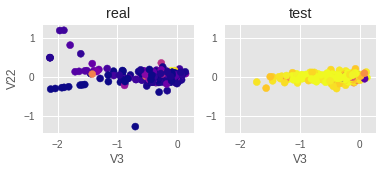

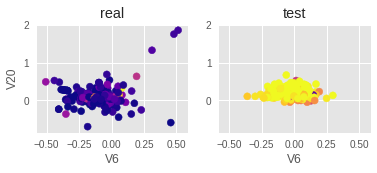

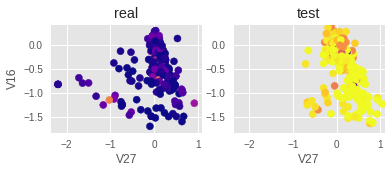

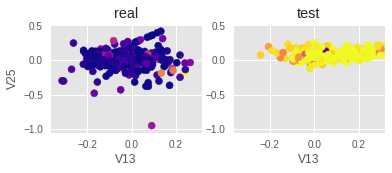

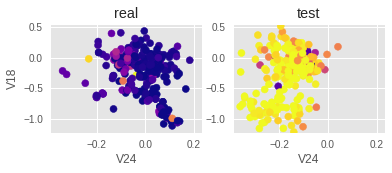

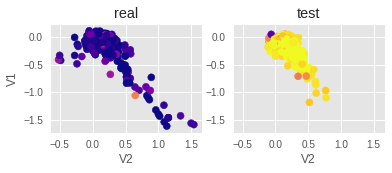

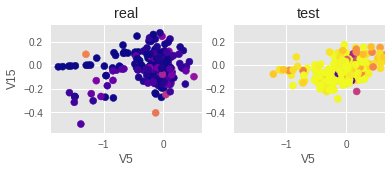

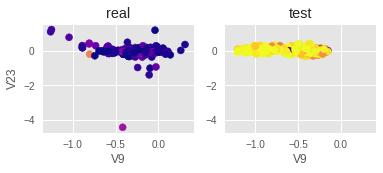

In [60]:
# Let's look at how the discrimnator scored real and generated data, visualized along every feature

y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

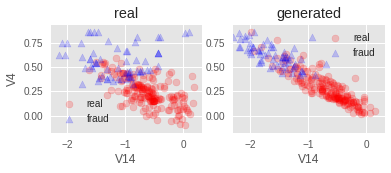

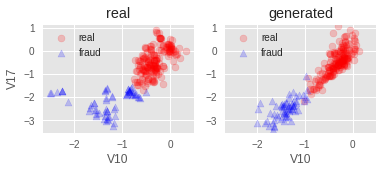

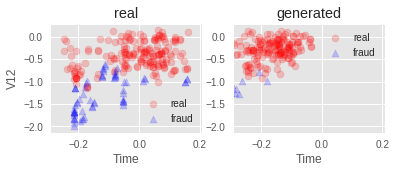

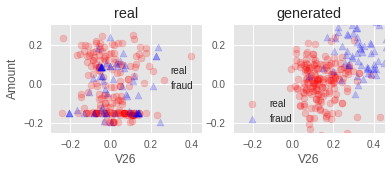

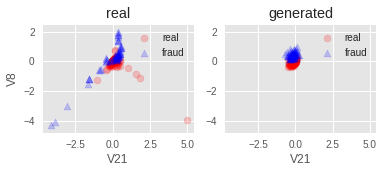

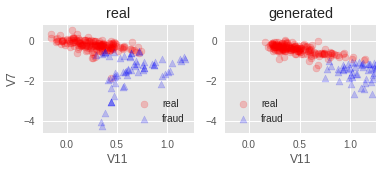

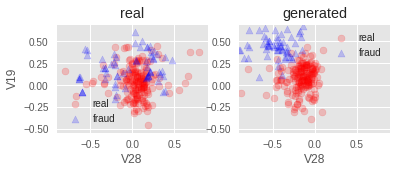

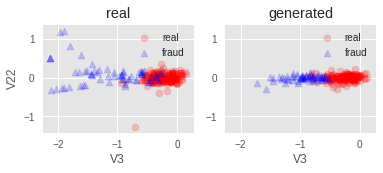

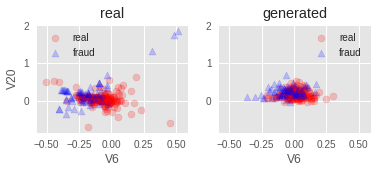

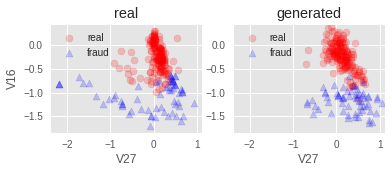

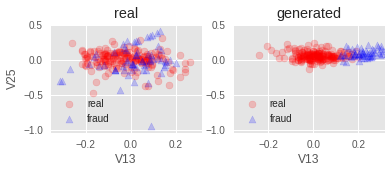

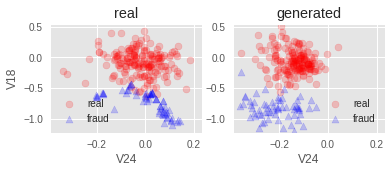

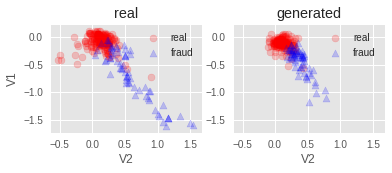

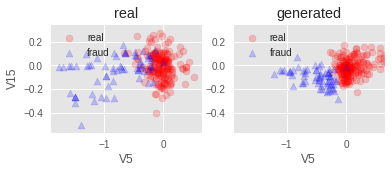

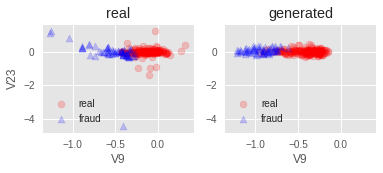

In [61]:
# Now we can compare the real and generated data by class, along every feature

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']

class_label = 'Class'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

In [62]:
# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,244,2
True 1,4,242


Accuracy : 0.9878048780487805


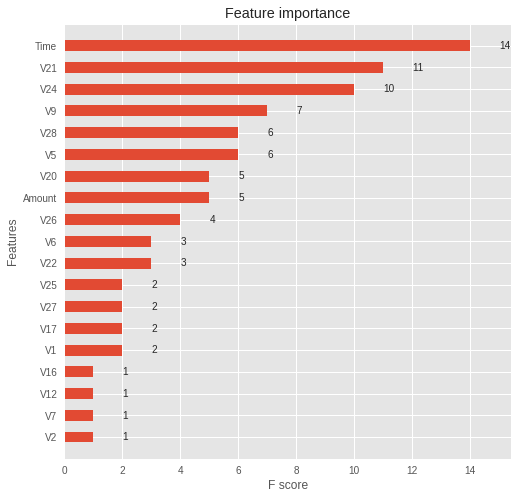

In [63]:
# Plot feature importances used for identifying generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);


Generated Data Testing

Table of contents

In [0]:
# Setup xgboost parameters

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [0]:
# Define model parameters

seed = 17
np.random.seed(seed)

data_dim = len(data_cols)
label_dim = len(label_cols)

base_dir = '/content/gdrive/My Drive/cache/'
rand_dim = 32
base_n_count = 128

In [0]:
# defined training set parameters

train_fraction = 0.7
X_col = data.columns[:-1]
y_col = data.columns[-1]

folds = 5

In [0]:
# Function to make cross folds with different amounts of an additional dataset added

def MakeCrossFolds( g_z_df=[] ):

    np.random.seed(0)

    train_real_set, test_real_set = [], []
    train_fraud_set, test_fraud_set = [], []

    real_samples = data.loc[ data.Class==0 ].copy()
    fraud_samples = data.loc[ data.Class==1 ].copy()

#     n_temp_real = 10000 
    n_temp_real = len(real_samples)

    for seed in range(folds):
        np.random.seed(seed)

        fraud_samples = fraud_samples.sample(len(fraud_samples), replace=False).reset_index(drop=True) # shuffle

    #     n_train_fraud = int(len(fraud_samples) * train_fraction)
        n_train_fraud = 100
        train_fraud_samples = fraud_samples[:n_train_fraud].reset_index(drop=True)

    #     test_fraud_samples = fraud_samples[n_train_fraud:].reset_index(drop=True)
        n_test_fraud = 148 # 30% left out
        test_fraud_samples = fraud_samples[-n_test_fraud:].reset_index(drop=True)

        if len(g_z_df)==0: g_z_df = fraud_samples[n_train_fraud:-n_test_fraud] # for adding real data, if no generated
        n_g_z = len(g_z_df)
        train_fraud_samples = train_fraud_samples.append(g_z_df).reset_index(drop=True)

        real_samples = real_samples.sample(len(real_samples), replace=False).reset_index(drop=True) # shuffle
        temp_real_samples = real_samples[:n_temp_real]
        n_train_real = int(len(temp_real_samples) * train_fraction)

        train_real_samples = temp_real_samples[:n_train_real].reset_index(drop=True) # with margin
        test_real_samples = temp_real_samples[n_train_real:].reset_index(drop=True) # with margin

        train_real_set.append( train_real_samples )
        test_real_set.append( test_real_samples )
        train_fraud_set.append( train_fraud_samples )
        test_fraud_set.append( test_fraud_samples )

    print( n_train_fraud )
    for i in [ fraud_samples, g_z_df, train_fraud_samples, test_fraud_samples ]: print( len(i) )
    for i in [ real_samples, train_real_samples, test_real_samples ]: print( len(i) )
    # [ [ len(i) for i in j ] for j in [train_real_set, test_real_set, train_fraud_set, test_fraud_set] ]
    
    return n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set

In [0]:
# function to run an xgboost classifier on different cross-folds with different amounts of data added

def Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set):

    test_data=[]

    # for i in [1]:
    # for i in [1,2,5,10,20]:
    # for i in np.logspace(0,np.log10(11),num=5):
    # for i in np.logspace(0,np.log10(11),num=3):
    for i in np.logspace(0,np.log10((492-148)/100),num=5):

        print('# additional generated data tested: {}'.format (int(n_train_fraud*(i-1)) ) )
        for k in range(folds):

            train_df = pd.concat( 
                [ train_real_set[k], train_fraud_set[k][:int(n_train_fraud*i)] ],
                 axis=0,ignore_index=True).reset_index(drop=True)

            test_df = pd.concat( 
                [ test_real_set[k], test_fraud_set[k] ],
                axis=0,ignore_index=True).reset_index(drop=True)

            dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
            dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

            results_dict = {}
            xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                                 verbose_eval=False, early_stopping_rounds=10, 
                                 evals=[(dtrain,'train'),(dtest,'test')],
                                 evals_result = results_dict )

            y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
            y_true = test_df['Class'].values
            results = [k, i, xgb_test.best_iteration, recall( y_pred, dtest )[1], precision( y_pred, dtest )[1], roc_auc( y_pred, dtest )[1] ]
            print(results)

            test_data.append(results)
    test_data = pd.DataFrame(test_data, columns=['k', 'ratio','best','recall','precision','auc'])
    return test_data

In [69]:
%%time

# Generate and test data with untrained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_0.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])


# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_0 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

100
492
492
592
148
284315
199020
85295
# additional generated data tested: 0
[0, 1.0, 27, 0.6554054054054054, 0.9603960396039604, 0.9692679460631861]
[1, 1.0, 42, 0.7027027027027027, 1.0, 0.978758418715333]
[2, 1.0, 52, 0.6959459459459459, 0.944954128440367, 0.9849418472930987]
[3, 1.0, 32, 0.6891891891891891, 0.9532710280373832, 0.9714340769634162]
[4, 1.0, 26, 0.7094594594594594, 0.9813084112149533, 0.982105348211216]
# additional generated data tested: 36
[0, 1.3618824101585059, 15, 0.668918918918919, 0.9611650485436893, 0.9576573275896214]
[1, 1.3618824101585059, 47, 0.7094594594594594, 1.0, 0.9718888182983382]
[2, 1.3618824101585059, 77, 0.6959459459459459, 0.9363636363636364, 0.9844648857779756]
[3, 1.3618824101585059, 42, 0.6824324324324325, 0.9619047619047619, 0.9623144159459301]
[4, 1.3618824101585059, 27, 0.7432432432432432, 0.990990990990991, 0.986248916716705]
# additional generated data tested: 85
[0, 1.854723699099141, 34, 0.6554054054054054, 0.9797979797979798, 0.967256

In [70]:
%%time

# Generate and test data with trained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_500.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])



# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_500 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

100
492
492
592
148
284315
199020
85295
# additional generated data tested: 0
[0, 1.0, 27, 0.6554054054054054, 0.9603960396039604, 0.9692679460631861]
[1, 1.0, 42, 0.7027027027027027, 1.0, 0.978758418715333]
[2, 1.0, 52, 0.6959459459459459, 0.944954128440367, 0.9849418472930987]
[3, 1.0, 32, 0.6891891891891891, 0.9532710280373832, 0.9714340769634162]
[4, 1.0, 26, 0.7094594594594594, 0.9813084112149533, 0.982105348211216]
# additional generated data tested: 36
[0, 1.3618824101585059, 27, 0.6756756756756757, 0.9803921568627451, 0.9701938661212358]
[1, 1.3618824101585059, 25, 0.7567567567567568, 0.9655172413793104, 0.9719352390669583]
[2, 1.3618824101585059, 19, 0.7432432432432432, 0.9243697478991597, 0.9781906752875157]
[3, 1.3618824101585059, 31, 0.6891891891891891, 0.9622641509433962, 0.9640642254306595]
[4, 1.3618824101585059, 23, 0.722972972972973, 0.963963963963964, 0.9838929438847372]
# additional generated data tested: 85
[0, 1.854723699099141, 9, 0.6351351351351351, 0.95918367346

In [71]:
%%time

# Generate and test data with additional real data

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds()
    
t_real = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

100
492
244
344
148
284315
199020
85295
# additional generated data tested: 0
[0, 1.0, 27, 0.6554054054054054, 0.9603960396039604, 0.9692679460631861]
[1, 1.0, 42, 0.7027027027027027, 1.0, 0.978758418715333]
[2, 1.0, 52, 0.6959459459459459, 0.944954128440367, 0.9849418472930987]
[3, 1.0, 32, 0.6891891891891891, 0.9532710280373832, 0.9714340769634162]
[4, 1.0, 26, 0.7094594594594594, 0.9813084112149533, 0.982105348211216]
# additional generated data tested: 36
[0, 1.3618824101585059, 28, 0.6891891891891891, 0.9902912621359223, 0.9760141274400609]
[1, 1.3618824101585059, 31, 0.75, 0.9910714285714286, 0.9875015645224918]
[2, 1.3618824101585059, 36, 0.722972972972973, 0.9385964912280702, 0.9886039785608929]
[3, 1.3618824101585059, 46, 0.7162162162162162, 0.9636363636363636, 0.9807040905727815]
[4, 1.3618824101585059, 38, 0.7702702702702703, 0.991304347826087, 0.9853490192226343]
# additional generated data tested: 85
[0, 1.854723699099141, 35, 0.722972972972973, 0.981651376146789, 0.976747